In [1]:
from myfunc import stochastic, finfunc
import pandas as pd

In [2]:
# グラフ、桁数表記設定
from myfunc.utility import pref
pref()

<AxesSubplot:>

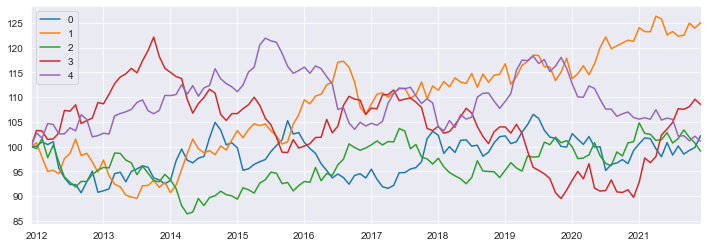

In [3]:
# パスの生成
gbm = stochastic.geometric_brownian_motion(M=120, npath=5)
dates = pd.date_range(end='2021-12-31', periods=len(gbm), freq='BM')
df = pd.DataFrame(gbm, index=dates)
df.plot()

In [4]:
ts = pd.DataFrame({'price': df.iloc[:, 0]})
ts['return'] = ts['price'].pct_change()
ts

,price,return
2011-12-30,100.000000,NaN
2012-01-31,100.076856,0.000769
2012-02-29,100.943355,0.008658
2012-03-30,100.403477,-0.005348
2012-04-30,100.988077,0.005823
...,...,...
2021-08-31,100.117955,0.018701
2021-09-30,98.468165,-0.016478
2021-10-29,99.223501,0.007671
2021-11-30,99.825600,0.006068


In [5]:
ts[['mean', 'var', 'skew', 'kurt']] = finfunc.rolling_mvsk(
    ts['return'], window=12)[['mean', 'var', 'skew', 'kurt']]

In [6]:
ts

,price,return,mean,var,skew,kurt
2011-12-30,100.000000,NaN,NaN,NaN,NaN,NaN
2012-01-31,100.076856,0.000769,NaN,NaN,NaN,NaN
2012-02-29,100.943355,0.008658,NaN,NaN,NaN,NaN
2012-03-30,100.403477,-0.005348,NaN,NaN,NaN,NaN
2012-04-30,100.988077,0.005823,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-08-31,100.117955,0.018701,0.003317,0.000324,-0.150886,-1.088630
2021-09-30,98.468165,-0.016478,0.001687,0.000357,0.055341,-1.463759
2021-10-29,99.223501,0.007671,0.001740,0.000358,0.046137,-1.473332
2021-11-30,99.825600,0.006068,0.002935,0.000349,-0.164668,-1.334205


In [7]:
df.apply(lambda x: finfunc.hurst(x.dropna()))

0   -0.041798
1    0.062163
2    0.061647
3    0.061985
4    0.128472
dtype: float64

(<Figure size 864x288 with 1 Axes>, <Figure size 864x288 with 1 Axes>)

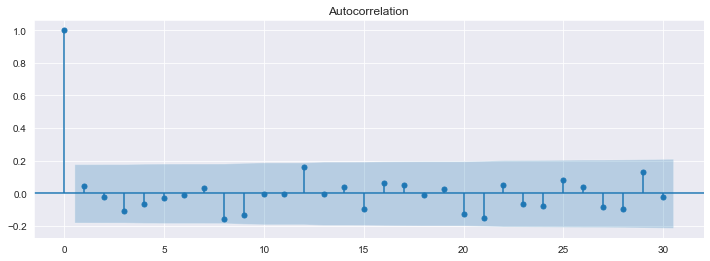

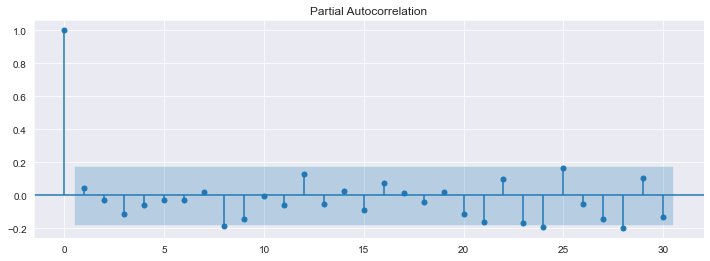

In [8]:
ts_r = ts['return'].dropna()
finfunc.acf_plot(ts_r)

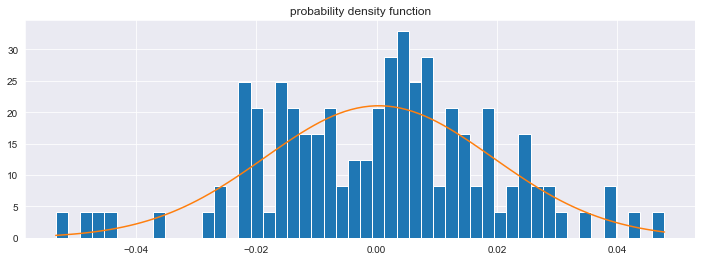

In [9]:
finfunc.histgram_pdf(ts_r)

<AxesSubplot:xlabel='freq/y'>

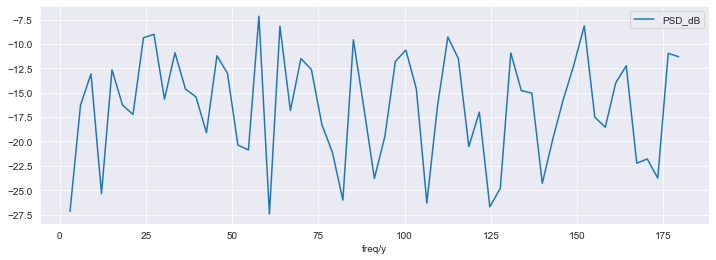

In [10]:
finfunc.fast_Fourier_transform_psd(ts_r.values).plot(legend=True)

<AxesSubplot:>

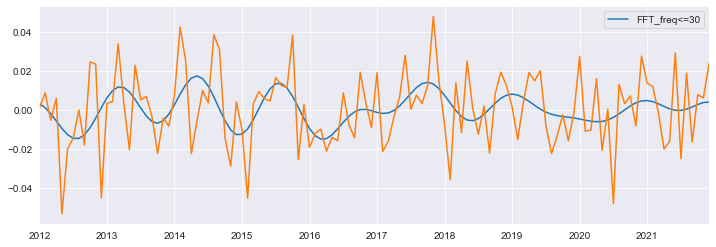

In [11]:
finfunc.fast_Fourier_transform(ts_r, freq_cut=30).plot(legend=True)
ts_r.plot()

<AxesSubplot:>

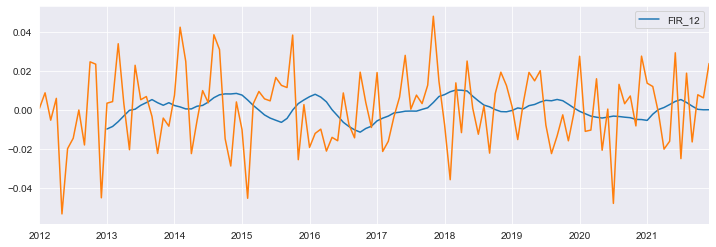

In [12]:
finfunc.filter_finite_impulse_response(ts_r, window=12).plot(legend=True)
ts_r.plot()

<AxesSubplot:>

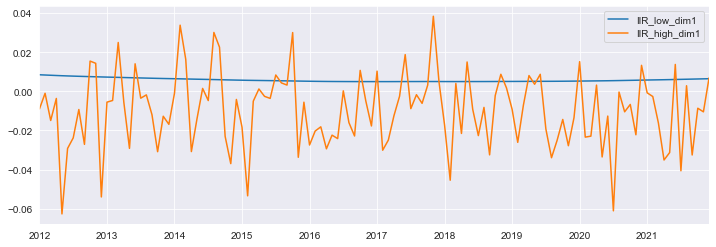

In [13]:
finfunc.filter_IIR_Butterworth(ts_r, dimension=1).plot(legend=True)

In [14]:
# rolling features
w = 12
l_ = list()
for i in range(w, len(ts_r)):
    x = ts_r[i-w:i]
    l_.append((
        finfunc.fast_Fourier_transform(x, freq_cut=30)[-1],
        finfunc.filter_finite_impulse_response(x, window=6)[-1],
        finfunc.filter_IIR_Butterworth(x, dimension=1).iloc[0, -1],
        finfunc.filter_IIR_Butterworth(x, dimension=1).iloc[1, -1],
    ))

ts = ts.join(
    pd.DataFrame(l_,
                 columns=['fft', 'fir', 'iir_low', 'iir_high'], index=ts_r.index[w:])
)

In [15]:
import statsmodels.api as sm
SARIMA_fit = sm.tsa.SARIMAX(ts_r, order=(
    3, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()
SARIMA_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.07804D+00    |proj g|=  8.42321D+00

At iterate    5    f= -2.09388D+00    |proj g|=  4.26919D-01


 This problem is unconstrained.



At iterate   10    f= -2.10670D+00    |proj g|=  6.21962D+00

At iterate   15    f= -2.11448D+00    |proj g|=  1.66894D-01

At iterate   20    f= -2.11831D+00    |proj g|=  3.32097D+00

At iterate   25    f= -2.12207D+00    |proj g|=  6.62140D-02

At iterate   30    f= -2.12691D+00    |proj g|=  2.08821D+00

At iterate   35    f= -2.14684D+00    |proj g|=  8.61187D-02

At iterate   40    f= -2.14961D+00    |proj g|=  2.11735D-01

At iterate   45    f= -2.15357D+00    |proj g|=  4.29410D-01

At iterate   50    f= -2.15388D+00    |proj g|=  8.10836D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70   

/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               return   No. Observations:                  120
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 258.465
Date:                              Sat, 19 Feb 2022   AIC                           -500.931
Time:                                      13:02:34   BIC                           -479.548
Sample:                                  01-31-2012   HQIC                          -492.262
                                       - 12-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5188      3.475     -0.149      0.881      -7.330       6.292
ar.L2         -0.0123      0.409     -0.030      0.976      -0.814       0.790
ar.L3         -0.0664      0.267     -0.248      0.804      -0.591       0.458
ma.L1         -0.3465      3.485     -0.099      0.921      -7.176       6.483
ma.L2         -0.6076      3.382     -0.180      0.857      -7.236       6.021
ar.S.L12       0.2401      0.206      1.167      0.243      -0.163       0.643
ma.S.L12      -0.9005      0.335     -2.684      0.007      -1.558      -0.243
sigma2         0.0004      0.000      3.650      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.11
Prob(Q):                              0.88   Prob(JB):                         0.35
Heteroskedasticity (H):               0.51   Skew:                            -0.30
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/user/.pyenv/versions/3.7.8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

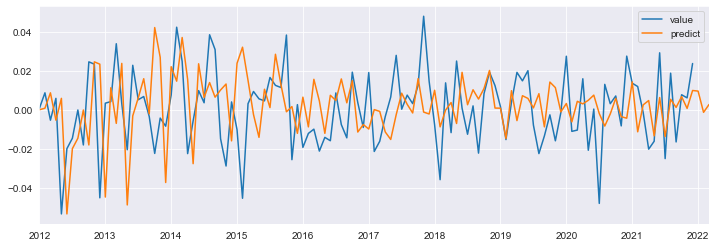

In [16]:
finfunc.statmodels_predict(SARIMA_fit, 3).plot()

<AxesSubplot:>

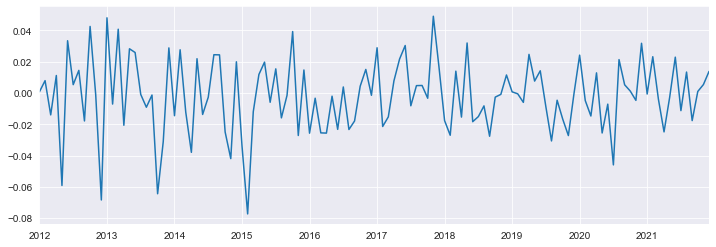

In [17]:
SARIMA_fit.resid.plot()

(<Figure size 864x288 with 1 Axes>, <Figure size 864x288 with 1 Axes>)

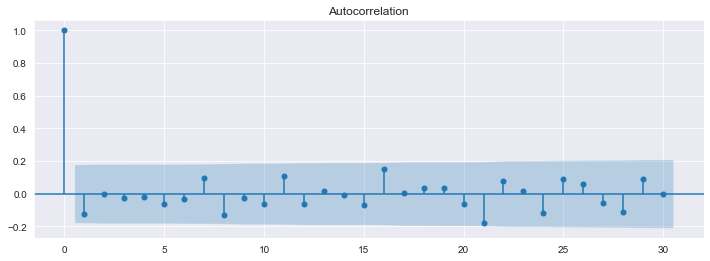

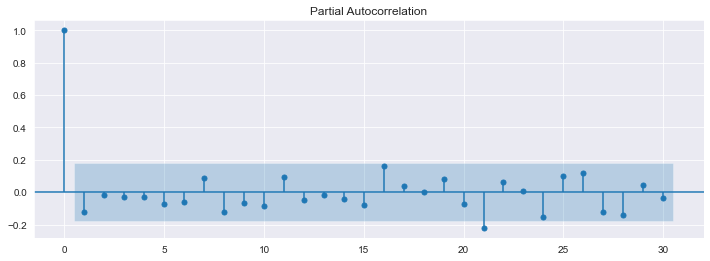

In [18]:
finfunc.acf_plot(SARIMA_fit.resid)

In [19]:
from sklearn.model_selection import train_test_split
ts_target = ts.shift().dropna().iloc[:, 1]  # 1month delay
ts_features = ts.dropna().iloc[1:, 2:]  # 1month cut
ts_train_test = train_test_split(
    ts_features, ts_target, random_state=0, shuffle=False, test_size=0.2)

In [20]:
ts_features.tail(3)

,mean,var,skew,kurt,fft,fir,iir_low,iir_high
2021-10-29,0.001740,0.000358,0.046137,-1.473332,0.001687,-0.001754,0.023562,0.009081
2021-11-30,0.002935,0.000349,-0.164668,-1.334205,0.001740,-0.000940,-0.034416,0.000799
2021-12-31,0.002620,0.000333,-0.218575,-1.349497,0.002935,0.002001,-0.000053,-0.013890


features_model                                        LinearRegression()
score                                                               0.84
n_features_original                                                    8
coef                   [0.52, 0.67, -0.0, 0.0, 0.99, -0.59, -0.32, -0...
intercept                                                            0.0
dtype: object


<AxesSubplot:>

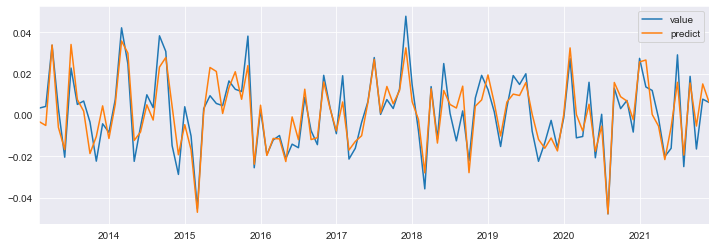

In [21]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
finfunc.sklearn_predict_regression(ols, ts_train_test).plot()

features_model                                         Ridge(alpha=0.5)
score                                                               0.3
n_features_original                                                   8
coef                   [0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.06, -0.06]
intercept                                                           0.0
dtype: object


<AxesSubplot:>

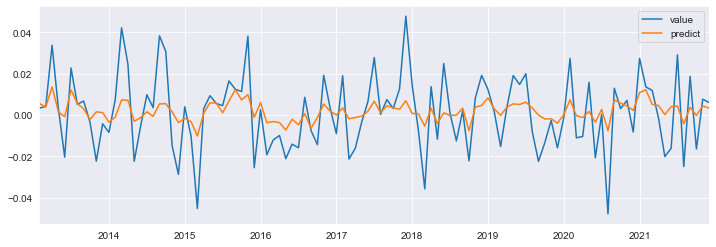

In [22]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.5)
finfunc.sklearn_predict_regression(ridge, ts_train_test).plot()

features_model         RFECV(estimator=LinearRegression(), scoring='n...
score                                                               0.84
n_features_original                                                    8
coef                                                                None
intercept                                                           None
dtype: object


,mean,var,skew,kurt,fft,fir,iir_low,iir_high
flg,True,True,False,False,True,True,True,True
rank,1,1,2,3,1,1,1,1


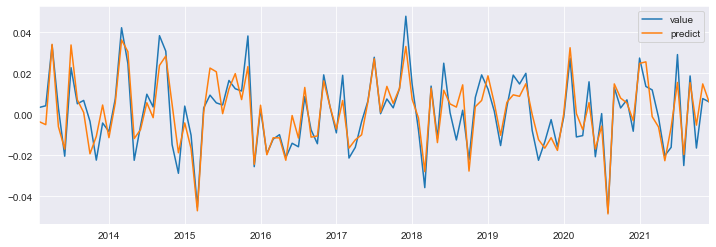

In [23]:
# 再帰的特徴量除去
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=ols, step=1, scoring="neg_mean_squared_error")
finfunc.sklearn_predict_regression(rfecv, ts_train_test).plot()

# 維持すべき特徴量
pd.DataFrame({
    'flg': rfecv.support_,
    'rank': rfecv.ranking_
}, index=ts_train_test[0].columns).T